# Непараметрические криетрии

  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Mirrors as potential environmental enrichment for individually housed laboratory mice

(Sherwin, 2004): 16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

In [9]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [10]:
path = 'https://raw.githubusercontent.com/chekhovana/courses/main/machine_learning/4_inference/2_%20ab_testing/data/2.5_mirror_mouses.txt'
mouses_data = pd.read_csv(path, header = None)
mouses_data.columns = ['proportion_of_time']

In [11]:
mouses_data.describe()

,proportion_of_time
count,16.000000
mean,0.475289
std,0.066065
min,0.348471
25%,0.444566
50%,0.477289
75%,0.488859
max,0.640620


proportion_of_time - доля времени, проведенного мышью в клетке с зеркалом

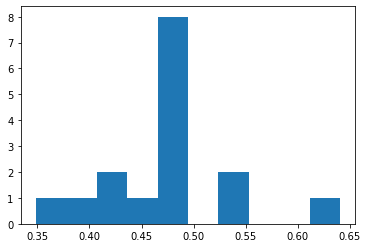

In [12]:
pylab.hist(mouses_data.proportion_of_time)
pylab.show()

## Одновыборочные критерии

Оценим доверительный интервал на время, проведенное в комнате с зеркалом

In [13]:
print(f'95%% confidence interval for the mean time: {zconfint(mouses_data)}')

95%% confidence interval for the mean time: (array([0.44291783]), array([0.50765996]))


### Критерий знаков

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

In [14]:
M, p = sign_test(mouses_data, 0.5)
print(f'M: {M},  p-value: {p}')

M: -5.0,  p-value: 0.021270751953125


**Вывод: данный критерий позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05**

### Критерий знаковых рангов Вилкоксона

In [16]:
m0 = 0.5
stats.wilcoxon(mouses_data.proportion_of_time - m0)

WilcoxonResult(statistic=35.0, pvalue=0.08793560714236243)

**Вывод: при использовании данного критерия нулевую гипотезу можно отвергнуть при уровне значимости 0.1

### Перестановочный критерий

$H_0\colon$ среднее равно 0.5

$H_1\colon$ среднее не равно 0.5

Функция, реализующая расчет статистики критерия по выборке (сумма центрированных средних)

In [53]:
def permutation_t_stat_1sample(sample, mean):
    return (np.array(sample) - mean).sum()

In [63]:
permutation_t_stat_1sample(mouses_data.proportion_of_time, 0.5)

-0.3953776999999997

Функция, реализующая расчет распределения перестановочного критерия

In [79]:
def permutation_zero_distr_1sample(sample, mean, max_permutations=None):
    centered_sample = np.array(sample) - mean
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, 
            size = (max_permutations, len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

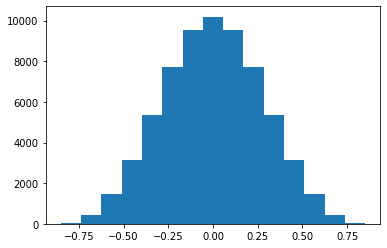

In [80]:
pylab.hist(list(permutation_zero_distr_1sample(mouses_data.proportion_of_time, 0.5)), bins = 15)
pylab.show()

In [81]:
def permutation_test(sample, mean, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [82]:
print(f"p-value: {permutation_test(mouses_data.proportion_of_time, 0.5)}")

p-value: 0.15777587890625


In [83]:
print(f"p-value: %f {permutation_test(mouses_data.proportion_of_time, 0.5, 10000)}")

p-value: %f 0.1571444000432012


Вывод: полученный уровень значимости не позволяет отвергнуть нулевую гипотезу